In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
transform = transforms.ToTensor()

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

9913344it [00:00, 10574892.49it/s]                             


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


29696it [00:00, 6729377.69it/s]          


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




 27%|██▋       | 448512/1648877 [00:00<00:00, 4282354.88it/s]

1649664it [00:00, 5194483.53it/s]                            


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



5120it [00:00, 12250334.56it/s]         

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw




/opt/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1623459044803/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [12]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 5*5*16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [13]:
torch.manual_seed(3)
model = CNNModel()
batchsize = 5

train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True)
test_loader = DataLoader(test_data, batch_size=100000, shuffle=False)

In [14]:
for i, (X_train, y_train) in enumerate(train_loader):
    y_pred = model(X_train)
    break


In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [16]:
epochs = 3
loss_list = []
accuracy_list = []

loss_temp = 0

for epoch in range(epochs):
    correct_counter = 0

    for i, (X_train, y_train) in enumerate(train_loader):
        i += 1
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        predicted_y = torch.max(y_pred.data, 1)[1]
        correct_temp = (predicted_y == y_train).sum()
        correct_counter += correct_temp
        loss_temp += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 1200 == 0:
            lossval = loss_temp / 1200
            print(f'Epoch: {epoch+1} {5*i}/60000 loss: {lossval:.3f} accuracy: {correct_counter.item()*100/(6000):.3f}')

            loss_list.append(lossval)
            accuracy_list.append(correct_counter.item()*100/6000)
            loss_temp = 0
            correct_counter = 0

Epoch: 1 6000/60000 loss: 0.510 accuracy: 83.017
Epoch: 1 12000/60000 loss: 0.175 accuracy: 94.317
Epoch: 1 18000/60000 loss: 0.151 accuracy: 95.233
Epoch: 1 24000/60000 loss: 0.125 accuracy: 96.367
Epoch: 1 30000/60000 loss: 0.107 accuracy: 96.717
Epoch: 1 36000/60000 loss: 0.093 accuracy: 97.217
Epoch: 1 42000/60000 loss: 0.089 accuracy: 97.467
Epoch: 1 48000/60000 loss: 0.083 accuracy: 97.667
Epoch: 1 54000/60000 loss: 0.087 accuracy: 97.500
Epoch: 1 60000/60000 loss: 0.072 accuracy: 97.750
Epoch: 2 6000/60000 loss: 0.066 accuracy: 97.950
Epoch: 2 12000/60000 loss: 0.069 accuracy: 97.717
Epoch: 2 18000/60000 loss: 0.056 accuracy: 98.383
Epoch: 2 24000/60000 loss: 0.066 accuracy: 97.917
Epoch: 2 30000/60000 loss: 0.056 accuracy: 98.183
Epoch: 2 36000/60000 loss: 0.052 accuracy: 98.300
Epoch: 2 42000/60000 loss: 0.059 accuracy: 98.100
Epoch: 2 48000/60000 loss: 0.059 accuracy: 98.300
Epoch: 2 54000/60000 loss: 0.058 accuracy: 98.217
Epoch: 2 60000/60000 loss: 0.055 accuracy: 98.400
Ep

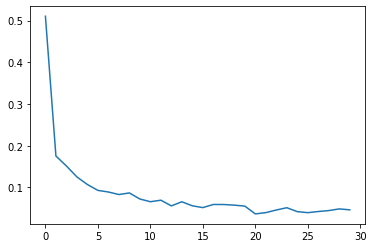

In [17]:
plt.plot(loss_list)

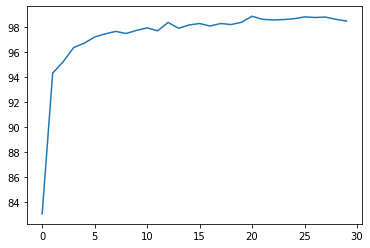

In [18]:
plt.plot(accuracy_list)

In [20]:
test_accuracy = 0

with torch.no_grad():
    for i, (X_test, y_test) in enumerate(test_loader):
        y_val = model(X_test)

        predicted = torch.max(y_val.data, 1)[1]
        test_accuracy += (predicted == y_test).sum()
        print(f'{test_accuracy.item()*100/len(y_test)}%')

98.74%
